## Import librerie e funzioni

In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
import KMeans
%matplotlib inline


In [2]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

## Import dataset

In [3]:
DIR_DATASET = "./data_set/"
filename = "N-CMAPSS_DS01-005.h5"

In [4]:
file_list = ["N-CMAPSS_DS01-005.h5",
             "N-CMAPSS_DS03-012.h5",
             "N-CMAPSS_DS04.h5",
             "N-CMAPSS_DS05.h5",
             "N-CMAPSS_DS06.h5",
             "N-CMAPSS_DS07.h5",
             "N-CMAPSS_DS08a-009.h5",
             "N-CMAPSS_DS08c-008.h5"]

In [5]:
# Load data

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root

unit = 1
df_complete = pd.DataFrame()
stationary_points_list = []
for filename in file_list:
        with h5py.File(DIR_DATASET + filename, 'r') as hdf:
                print(unit)
                # Development set
                W_dev = np.array(hdf.get('W_dev'))             # W
                X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
                X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
                T_dev = np.array(hdf.get('T_dev'))             # T
                Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
                A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

                # Test set
                W_test = np.array(hdf.get('W_test'))           # W
                X_s_test = np.array(hdf.get('X_s_test'))       # X_s
                X_v_test = np.array(hdf.get('X_v_test'))       # X_v
                T_test = np.array(hdf.get('T_test'))           # T
                Y_test = np.array(hdf.get('Y_test'))           # RUL  
                A_test = np.array(hdf.get('A_test'))           # Auxiliary
                
                # Varnams
                W_var = np.array(hdf.get('W_var'))
                X_s_var = np.array(hdf.get('X_s_var'))  
                X_v_var = np.array(hdf.get('X_v_var')) 
                T_var = np.array(hdf.get('T_var'))
                A_var = np.array(hdf.get('A_var'))
                
                # from np.array to list dtype U4/U5
                W_var = list(np.array(W_var, dtype='U20'))
                X_s_var = list(np.array(X_s_var, dtype='U20'))  
                X_v_var = list(np.array(X_v_var, dtype='U20')) 
                T_var = list(np.array(T_var, dtype='U20'))
                A_var = list(np.array(A_var, dtype='U20'))
                                
                W = np.concatenate((W_dev, W_test), axis=0)  
                X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
                X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
                T = np.concatenate((T_dev, T_test), axis=0)
                Y = np.concatenate((Y_dev, Y_test), axis=0) 
                A = np.concatenate((A_dev, A_test), axis=0) 
                
                df_A = DataFrame(data=A, columns=A_var)
                df_W = DataFrame(data=W, columns=W_var)
                df_W['unit'] = df_A['unit'].values
                df_W['cycle'] = df_A['cycle'].values
                x = np.array(np.arange(len(df_W)))
                y = np.array(df_W['alt'].to_list())

                # calcolare la derivata
                dy_dx = np.gradient(y, x)

                # trovare i punti stazionari
                stationary_points = x[np.where(dy_dx == 0)[0]]

                print(stationary_points)

                stationary_points_list.append(stationary_points)

                df_W_cruise = df_W.iloc[stationary_points]
                df_W_cruise.reset_index(inplace=True)
                df_W_cruise.drop(columns=["index"],inplace=True)
                df_W = df_W_cruise.groupby(['unit']).mean()
                df_W["dataset"] = filename
                df_W = pd.DataFrame(df_W).reset_index()
                df_complete = df_complete.append(df_W, ignore_index=True)
                unit +=1

1
[    835     846     854 ... 7641612 7641619 7641623]
2
[   1201    1202    1205 ... 9821802 9821805 9821810]
3
[   2556    2559    2657 ... 9979327 9979328 9979330]
4
[   3013    3014    3017 ... 6910785 6910788 6910809]
5
[   3013    3014    3017 ... 6777789 6777792 6777813]
6
[   3013    3014    3017 ... 7217762 7217764 7217766]
7
[    768     781     782 ... 8607837 8608354 8608370]
8
[   1967    1968    1980 ... 6417673 6417675 6417679]


In [6]:
df_complete

,unit,alt,Mach,TRA,T2,cycle,dataset
0,1.0,10547.036158,0.489813,55.521499,504.548020,50.854599,N-CMAPSS_DS01-005.h5
1,2.0,21524.841238,0.609546,68.280922,475.378507,38.475814,N-CMAPSS_DS01-005.h5
2,3.0,16504.960390,0.546703,61.498156,488.014505,51.973662,N-CMAPSS_DS01-005.h5
3,4.0,10405.109537,0.480849,55.035771,504.343155,49.128555,N-CMAPSS_DS01-005.h5
4,5.0,21209.136900,0.606055,67.189775,476.270787,45.106348,N-CMAPSS_DS01-005.h5
...,...,...,...,...,...,...,...
85,6.0,16975.284477,0.561377,62.077562,487.628154,30.426120,N-CMAPSS_DS08c-008.h5
86,7.0,15567.120851,0.535840,60.367960,490.391736,33.412798,N-CMAPSS_DS08c-008.h5
87,8.0,17048.353475,0.561054,62.249120,487.254629,30.826386,N-CMAPSS_DS08c-008.h5
88,9.0,17167.684985,0.565027,62.686385,487.169080,29.706391,N-CMAPSS_DS08c-008.h5


### Plot altezze

In [12]:
# #selezione unita e ciclo
# unit=1
# cycle=10

In [13]:
# #prima
# filter1 = df_W[df_W['unit']==unit]
# filter1 = filter1[filter1['cycle']==cycle]
# filter1.reset_index(inplace=True, drop=True)
# labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
# plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [14]:
# #dopo

# filter2 = df_W_cruise[df_W_cruise['unit']==unit]
# filter2 = filter2[filter2['cycle']==cycle]
# filter2.reset_index(inplace=True, drop=True)
# labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
# plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

In [15]:
# df_W_cruise = df_W_cruise.groupby(['unit', 'cycle']).max()
# df_W_cruise = pd.DataFrame(df_W_cruise).reset_index()

## Clustering

In [16]:
df_W_cruise_norm = KMeans.normalize_df(df_complete.drop(columns=["unit",'cycle',"dataset"]))

-3.6143927357241207e-16 1.0
(90, 4)


In [17]:
#calcolo wcss
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(df_W_cruise_norm)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9


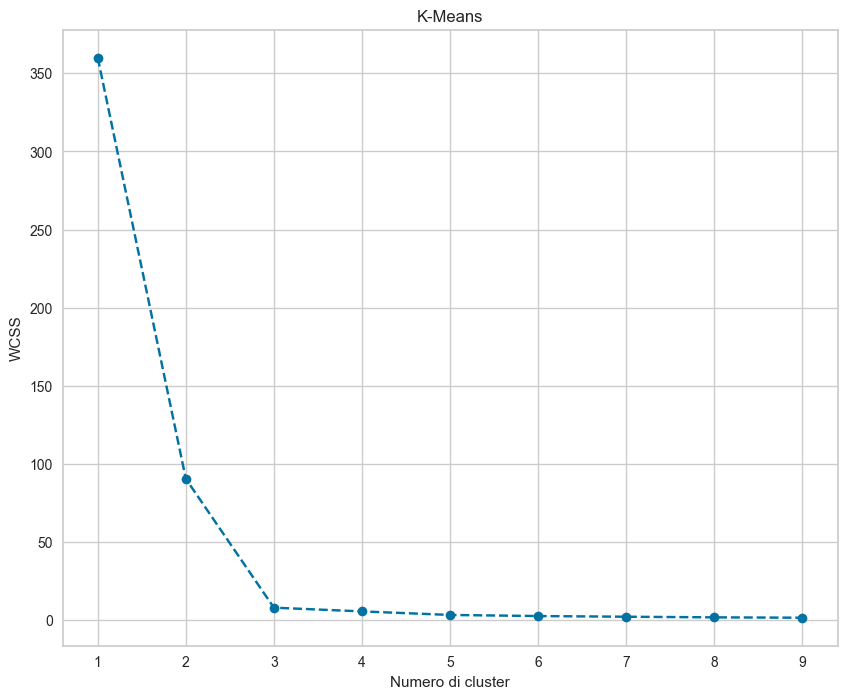

In [18]:
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")

In [19]:
kmeans_model = KMeans.KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_model.fit(df_W_cruise_norm)

KMeans(n_clusters=3, random_state=42)

0.85


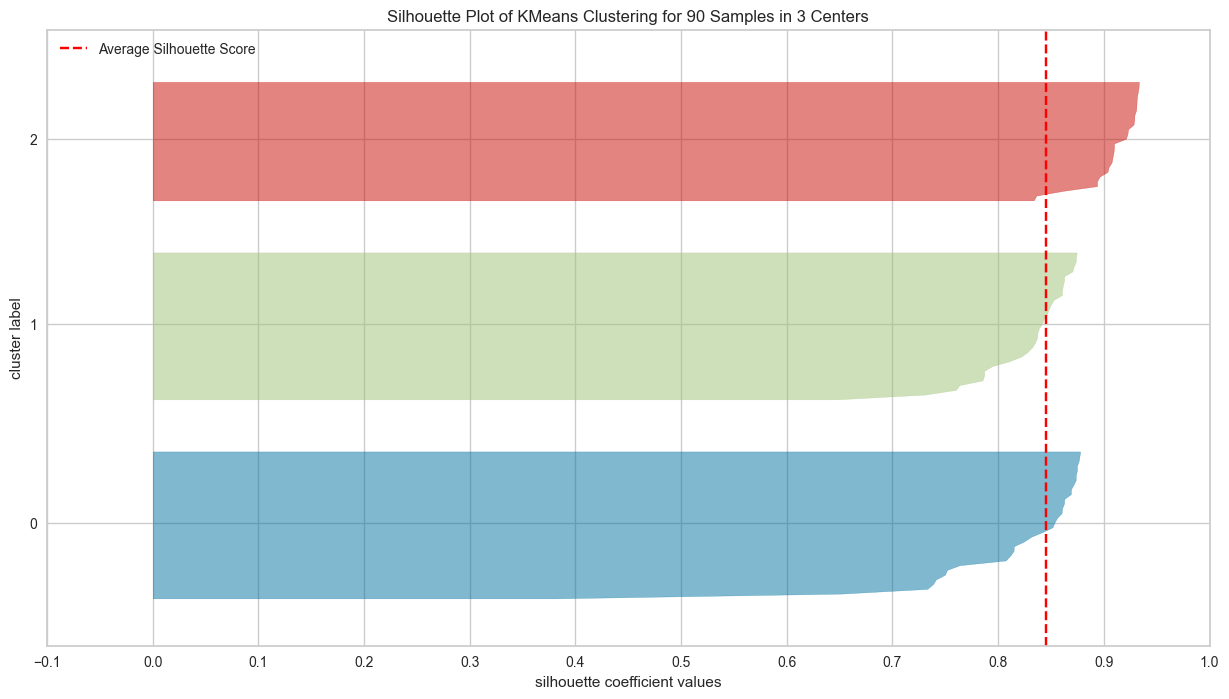

In [20]:
KMeans.evaluation(df_W_cruise_norm,kmeans_model)

## Salvataggio cluster con dati sensori

In [21]:
kmeans_model.labels_

array([2, 1, 0, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 1, 0, 1, 2, 1, 1, 2,
       1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 2, 1,
       2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2, 2,
       1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0])

In [22]:
def create_dict(dimension):
    dict = {}
    for i in range(0,dimension):
        dict[i] = str(i)
    return dict

df_W_cruise_cluster = df_complete
df_W_cruise_cluster['Segm K-means PCA'] = kmeans_model.labels_
df_W_cruise_cluster['Cluster'] = df_W_cruise_cluster['Segm K-means PCA'].map(create_dict(len(kmeans_model.labels_)))
df_W_cruise_cluster.drop(columns=['Segm K-means PCA'],inplace=True)
df_W_cruise_cluster

,unit,alt,Mach,TRA,T2,cycle,dataset,Cluster
0,1.0,10547.036158,0.489813,55.521499,504.548020,50.854599,N-CMAPSS_DS01-005.h5,2
1,2.0,21524.841238,0.609546,68.280922,475.378507,38.475814,N-CMAPSS_DS01-005.h5,1
2,3.0,16504.960390,0.546703,61.498156,488.014505,51.973662,N-CMAPSS_DS01-005.h5,0
3,4.0,10405.109537,0.480849,55.035771,504.343155,49.128555,N-CMAPSS_DS01-005.h5,2
4,5.0,21209.136900,0.606055,67.189775,476.270787,45.106348,N-CMAPSS_DS01-005.h5,1
...,...,...,...,...,...,...,...,...
85,6.0,16975.284477,0.561377,62.077562,487.628154,30.426120,N-CMAPSS_DS08c-008.h5,0
86,7.0,15567.120851,0.535840,60.367960,490.391736,33.412798,N-CMAPSS_DS08c-008.h5,0
87,8.0,17048.353475,0.561054,62.249120,487.254629,30.826386,N-CMAPSS_DS08c-008.h5,0
88,9.0,17167.684985,0.565027,62.686385,487.169080,29.706391,N-CMAPSS_DS08c-008.h5,0


In [43]:
new_unit = 1
k=0
unit=0
df_Xs_complete_cluster = pd.DataFrame()
for filename in file_list:
    dataset_filter_df = df_W_cruise_cluster[df_W_cruise_cluster['dataset'] == filename]
    with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        unit+=1
        print("unità " + str(unit))
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
                
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
                
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                                
        W = np.concatenate((W_dev, W_test), axis=0)  
        X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
        X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
        T = np.concatenate((T_dev, T_test), axis=0)
        Y = np.concatenate((Y_dev, Y_test), axis=0) 
        A = np.concatenate((A_dev, A_test), axis=0) 
                
        df_A = DataFrame(data=A, columns=A_var)
        df_W = DataFrame(data=W, columns=W_var)
        df_X_s = DataFrame(data=X_s, columns=X_s_var)
        
        stationary_points = stationary_points_list[k]
       
        df_X_s = df_X_s.iloc[stationary_points]
        df_A = df_A.iloc[stationary_points]
        df_W = df_W.iloc[stationary_points]
        
        df_X_s['unit'] = df_A['unit'].values
        df_X_s['cycle'] = df_A['cycle'].values
        df_W['unit'] = df_A['unit'].values
        df_W['cycle'] = df_A['cycle'].values

        for i in range(0,int(dataset_filter_df['unit'].max())):
            df_cluster_filter_unit = dataset_filter_df[dataset_filter_df['unit'] == i+1].reset_index(drop=True)
            df_cluster_filter_unit.drop(columns=['unit'])
            cluster = int(df_cluster_filter_unit["Cluster"])

            df_W_filter_unit = df_W[df_W['unit']==i+1].reset_index(drop=True)
            df_W_filter_unit.drop(columns = ["unit","cycle"],inplace = True)

            df_X_s_filter_unit = df_X_s[df_X_s['unit'] == i+1].reset_index(drop=True)
            df_X_s_filter_unit['unit'] = new_unit
            
            df_Xs_cluster_filter_union = pd.concat([df_X_s_filter_unit, df_W_filter_unit], axis=1)
            df_Xs_cluster_filter_union["Cluster"] = cluster
            df_Xs_complete_cluster = df_Xs_complete_cluster.append(df_Xs_cluster_filter_union, ignore_index=True)
            
            new_unit+=1            
    k+=1
    
df_Xs_complete_cluster


1
2
3
4
5
6
7
8


,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Nf,Nc,Wf,unit,cycle,alt,Mach,TRA,T2,Cluster
0,604.879374,1444.791411,1823.231700,1226.781171,16.110502,11.825509,16.355840,20.566123,335.320672,340.767170,...,2171.734447,8611.584529,3.902047,1,1.0,10471.0,0.509859,77.167419,506.352753,2
1,606.173383,1448.216471,1828.776041,1229.215502,16.201676,11.873190,16.448402,20.710063,338.140429,343.618754,...,2178.616072,8622.426147,3.944796,1,1.0,10485.0,0.516537,77.782646,506.961661,2
2,606.832019,1449.645919,1830.651114,1229.895271,16.252226,11.905501,16.499722,20.784766,339.347956,344.845923,...,2181.238652,8627.030795,3.961392,1,1.0,10492.0,0.520884,77.958427,507.368620,2
3,605.361445,1441.030577,1811.106511,1218.768242,16.174659,11.927127,16.420973,20.621049,332.387137,337.884497,...,2163.272231,8600.726864,3.834681,1,1.0,10497.0,0.523782,75.673286,507.641208,2
4,602.042145,1424.736293,1775.281503,1199.173623,15.990611,11.934432,16.234123,20.257418,319.504991,324.981979,...,2129.175122,8551.018104,3.606910,1,1.0,10498.0,0.524727,71.454567,507.731865,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7754281,588.042816,1361.430683,1675.865651,1205.557945,17.121997,13.671209,17.382738,20.573460,296.954398,302.164997,...,1883.941108,8325.919697,3.167387,90,54.0,3135.0,0.255150,47.724270,514.093739,0
7754282,571.891628,1290.621188,1543.166019,1152.735775,16.257810,13.650471,16.505391,18.856939,243.580590,248.350802,...,1680.032922,8082.306669,2.392890,90,54.0,3138.0,0.251118,32.255630,513.876238,0
7754283,578.976794,1328.234177,1616.606602,1182.870653,16.540981,13.489181,16.792874,19.541589,270.533944,275.489426,...,1793.503683,8211.887328,2.788691,90,54.0,3195.0,0.221130,40.605179,512.237125,0
7754284,578.943547,1328.235884,1616.975802,1183.216254,16.539206,13.488201,16.791072,19.537973,270.546408,275.496964,...,1793.207127,8211.756972,2.789958,90,54.0,3194.0,0.220815,40.605179,512.224683,0


In [48]:
# salvataggio
for i in range(0,3):
    df_Xs_complete_cluster[df_Xs_complete_cluster["Cluster"]==i].to_csv("./cluster_set/N-CMAPSS_cluster_"+str(i)+".csv",index=False)

In [5]:
for i in range(0,3):
    df = pd.read_csv("./cluster_set/N-CMAPSS_cluster_"+str(i)+".csv")
    df = df.groupby(['unit', 'cycle']).mean()
    df = pd.DataFrame(df).reset_index()
    df.to_csv("./cluster_set/N-CMAPSS_cluster_"+str(i)+"_cycle.csv",index=False)
df

,unit,cycle,T24,T30,T48,T50,P15,P2,P21,P24,...,P40,P50,Nf,Nc,Wf,alt,Mach,TRA,T2,Cluster
0,1,1.0,588.532233,1372.087866,1682.911509,1160.204117,15.287638,11.923405,15.520445,18.855488,...,286.170122,11.818140,1994.816696,8382.688405,3.023268,10485.668757,0.522697,58.922944,507.574541,2.0
1,1,2.0,581.943916,1354.946817,1657.369274,1143.355801,14.457278,11.326865,14.677439,17.796071,...,267.938006,11.131186,1973.265016,8326.518084,2.797029,11968.955331,0.531638,57.786028,502.906945,2.0
2,1,3.0,580.109683,1341.293418,1627.201983,1149.849256,15.310031,12.230712,15.543179,18.502999,...,271.133103,12.445561,1892.413895,8276.565803,2.778473,8317.011676,0.423908,49.982141,507.195949,2.0
3,1,4.0,584.484122,1354.978041,1650.020562,1153.699799,15.433885,12.234437,15.668919,18.789970,...,278.252997,12.263380,1933.552817,8323.758743,2.884313,9154.026217,0.476664,53.680490,508.353045,2.0
4,1,5.0,576.942419,1348.940577,1656.738973,1131.939750,13.395820,10.396321,13.599817,16.607465,...,253.125639,10.119206,1995.593423,8307.587735,2.652313,14736.786517,0.566025,61.207781,495.983720,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,80,68.0,584.429998,1356.125401,1651.572527,1159.726251,15.410888,12.236261,15.645572,18.826258,...,278.232861,12.323531,1939.868627,8315.107147,2.873453,8804.337110,0.455717,54.171196,508.200745,2.0
2236,80,69.0,577.573471,1341.964011,1636.270157,1135.958321,13.951496,11.043259,14.163956,17.172900,...,253.982735,10.793462,1958.456446,8271.615802,2.606025,12554.000000,0.526015,57.333752,500.326551,2.0
2237,80,70.0,576.272283,1345.532726,1647.103369,1137.258798,13.610329,10.673677,13.817593,16.855116,...,253.582815,10.524540,1986.373460,8285.317290,2.619099,13287.479042,0.522005,60.131671,496.968811,2.0
2238,80,71.0,588.696993,1369.303154,1675.637369,1157.837953,15.069113,11.857249,15.298592,18.693976,...,278.521895,11.529838,2006.512111,8357.871385,2.904029,11012.512456,0.543903,60.058740,507.763163,2.0
